In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-0569-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-0523-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-1285-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-1262-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-1017-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-0971-0001-0002.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-0937-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/IM-0561-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/IM-0425-0001.jpeg
/kaggle

/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/IM-0307-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/IM-0525-0001-0002.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/IM-0531-0001-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-0971-0001-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/IM-0663-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-1033-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-0414-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-0983-0001-0002.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-0491-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-1125-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_

/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person1415_virus_2425.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person162_virus_319.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person400_virus_794.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person490_virus_996.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person1710_bacteria_4526.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person110_virus_206.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person277_bacteria_1304.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person417_bacteria_1841.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person1217_virus_2063.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person1548_virus_2689.jpeg
/

/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person958_virus_1630.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person659_bacteria_2551.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person1924_bacteria_4832.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person558_virus_1098.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person297_virus_614.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person110_virus_207.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person441_bacteria_1910.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person772_virus_1401.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person837_virus_1475.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person1180_virus_2012.jpeg
/

/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person1535_virus_2672.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person1188_virus_2024.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person1315_virus_2270.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person1406_bacteria_3574.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person512_bacteria_2154.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person617_bacteria_2488.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person135_virus_271.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person510_virus_1026.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person368_bacteria_1667.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person1100_bacteria_3

/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0249-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0298-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0730-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/NORMAL/._NORMAL2-IM-0971-0001-0002.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0533-0001-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/NORMAL/._NORMAL2-IM-1043-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0216-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0274-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/NORMAL/._NORMAL2-IM-1128-0001-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/trai

/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person633_virus_1213.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person868_virus_1513.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person37_bacteria_188.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person810_bacteria_2719.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person1670_bacteria_4428.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person1294_virus_2222.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person71_bacteria_350.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person255_bacteria_1175.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person1222_virus_2071.j

/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person255_bacteria_1162.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person281_bacteria_1326.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person1344_virus_2320.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person905_bacteria_2830.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person419_virus_859.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person1254_virus_2130.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person531_bacteria_2235.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person549_bacteria_2304.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA/._person1_bacteria_2.j

/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/test/PNEUMONIA/._person59_virus_116.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/test/PNEUMONIA/._person96_bacteria_464.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/test/PNEUMONIA/._person111_bacteria_536.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/test/PNEUMONIA/._person80_bacteria_392.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/test/PNEUMONIA/._person1_virus_8.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/test/PNEUMONIA/._person60_virus_117.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/test/PNEUMONIA/._person80_bacteria_389.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/test/PNEUMONIA/._person8_virus_28.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/test/PNEUMONIA/._person39_virus_85.jpeg
/kaggle/input/chest-xray-pneum

/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-0569-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-0523-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-1285-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-1262-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-1017-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-0971-0001-0002.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-0937-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0561-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0425-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0372-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0526-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-1126-0001.jpeg
/kaggle

/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1415_virus_2425.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person162_virus_319.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person400_virus_794.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person490_virus_996.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1710_bacteria_4526.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person110_virus_206.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person277_bacteria_1304.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person417_bacteria_1841.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1217_virus_2063.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1548_virus_2689.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1281_virus_2204.jpeg
/kaggle/input/chest-xr

/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person45_bacteria_222.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person881_bacteria_2805.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1413_bacteria_3617.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1495_virus_2603.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1078_bacteria_3018.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1888_bacteria_4775.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person871_virus_1517.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1459_bacteria_3797.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person376_virus_759.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person334_virus_689.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1259_virus_2139.jpeg
/kaggle/inpu

/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person152_bacteria_722.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person111_bacteria_533.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person1676_virus_2892.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person133_bacteria_633.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person140_bacteria_668.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person139_bacteria_666.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person1613_virus_2799.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person1685_virus_2903.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person87_bacteria_434.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person92_bacteria_450.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person72_virus_133.jpeg
/kaggle/input/chest-xray-pneum

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten,BatchNormalization,Conv2D,MaxPool2D,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix,classification_report,log_loss
from keras.initializers import RandomNormal
import matplotlib.pyplot as plt
import glob
import random
import os
import seaborn as sns

In [3]:
train_path = r'../input/chest-xray-pneumonia/chest_xray/train'
test_path = r'../input/chest-xray-pneumonia/chest_xray/test'
val_path = r'../input/chest-xray-pneumonia/chest_xray/val'

datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, 
height_shift_range=0.1,shear_range=0.15, 
zoom_range=0.1,channel_shift_range = 10, horizontal_flip=True)

image_path = r'../input/chest-xray-pneumonia/chest_xray/train/NORMAL'
save_path = r'./'
for i in os.listdir(image_path):
    image = load_img(os.path.join(image_path,i))
    image = np.expand_dims(image,axis=0)
    datagen.fit(image)

    for x, val in zip(datagen.flow(image,                    #image we chose
        save_to_dir=save_path,     #this is where we figure out where to save
         save_prefix='aug',        # it will save the images as 'aug_0912' some number for every new augmented image
        save_format='jpeg'),range(1)) :     # here we define a range because we want 10 augmented images otherwise it will keep looping forever I think
        pass

In [4]:
datagen = ImageDataGenerator(rescale = 1/255, samplewise_std_normalization = True,
                            samplewise_center = True)

train_batch = datagen.flow_from_directory(directory=train_path
                                          ,batch_size = 30,target_size=(224,224),shuffle =True, seed=0,
                                          classes=['NORMAL','PNEUMONIA'])

test_batch = datagen.flow_from_directory(directory=test_path
                                          ,batch_size =16,target_size=(224,224),shuffle =False
                                          ,classes=['NORMAL','PNEUMONIA'])

val_batch = datagen.flow_from_directory(directory=val_path
                                          ,batch_size = 624,target_size=(224,224),shuffle =True
                                          ,classes=['NORMAL','PNEUMONIA'])
train_batch.class_indices

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


{'NORMAL': 0, 'PNEUMONIA': 1}

,Status,Img_name
0,NORMAL,NORMAL2-IM-0569-0001.jpeg
1,NORMAL,NORMAL2-IM-0523-0001.jpeg
2,NORMAL,NORMAL2-IM-1285-0001.jpeg
3,NORMAL,NORMAL2-IM-1262-0001.jpeg
4,NORMAL,NORMAL2-IM-1017-0001.jpeg
...,...,...
5211,PNEUMONIA,person675_bacteria_2569.jpeg
5212,PNEUMONIA,person509_virus_1025.jpeg
5213,PNEUMONIA,person162_virus_320.jpeg
5214,PNEUMONIA,person1637_bacteria_4339.jpeg


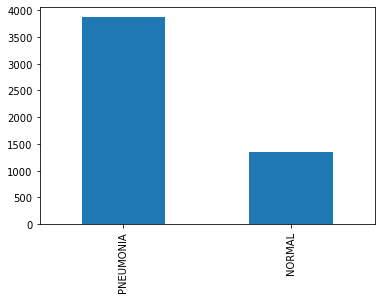

In [5]:
nor_path = r'../input/chest-xray-pneumonia/chest_xray/train/NORMAL/'
pneu_path = r'../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/'

label = ['NORMAL','PNEUMONIA']

files = [[j,k] for j in label for k in 
         os.listdir(os.path.join(r'../input/chest-xray-pneumonia/chest_xray/train',j))]
df = pd.DataFrame(files,columns=['Status','Img_name'])

df.Status.value_counts().plot(kind='bar')
df

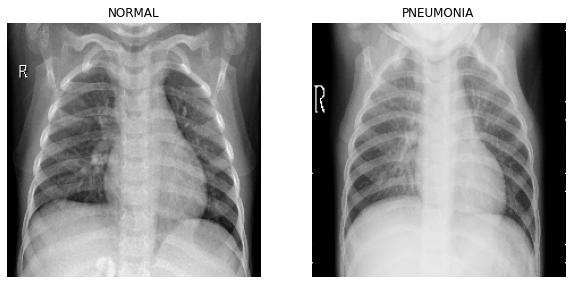

In [6]:
nor_img = load_img(os.path.join(nor_path, df[df.Status == 'NORMAL'].Img_name[0])
                   ,target_size=(224,224))
pne_img = load_img(os.path.join(pneu_path, df[df.Status == 'PNEUMONIA'].Img_name.iloc[2]),
                   target_size=(224,224))

def img_(nor_img,pne_img):
    plt.figure(figsize=(10,10))
    plt.subplot(121)
    plt.title('NORMAL')
    plt.imshow(nor_img)
    plt.axis('off')

    plt.subplot(122)
    plt.title('PNEUMONIA')
    plt.imshow(pne_img)
    plt.axis('off')
img_(nor_img,pne_img)

In [7]:
def result_plot(train_accuracy, val_accuracy,train_loss,val_loss):
    plt.figure(figsize=(15,5))
    
    plt.subplot(121)
    plt.plot(train_accuracy) , plt.plot(val_accuracy)
    plt.xticks(np.arange(1,len(train_accuracy)+1),np.arange(1,len(train_accuracy)+1))
    plt.xlabel('No.of Epoch'),plt.ylabel('Accuracy'),plt.legend(['train_accuracy','val_accuracy'],
                                                          bbox_to_anchor=(.575,.575,.575,.575))
    plt.ylim(0,1.2)
    
    plt.subplot(122)
    plt.plot(train_loss) , plt.plot(val_loss)
    plt.xticks(np.arange(1,len(train_accuracy)+1),np.arange(1,len(train_accuracy)+1))
    plt.xlabel('No. of Epoch'),plt.ylabel('loss'),plt.legend(['train_loss','val_loss'],
                                                          bbox_to_anchor=(.575,.575,.575,.575))
    plt.ylim(0,max(max(val_loss),max(train_loss)))
    

In [20]:
model = Sequential([Conv2D(filters = 9 ,kernel_size = (5,5), activation='relu', padding = 'valid',
                          input_shape = (224,224,3)),
                   MaxPool2D(pool_size = (2,2), strides = 2),
                   Conv2D(filters = 30 ,kernel_size = (3,3), activation='relu', padding = 'valid'),
                   MaxPool2D(pool_size = (2,2), strides = 2),
                    Conv2D(filters = 96 ,kernel_size = (3,3), activation='relu', padding = 'valid'),
                   MaxPool2D(pool_size = (2,2), strides = 2),
                    Conv2D(filters = 120 ,kernel_size = (3,3), activation='relu', padding = 'valid'),
                   MaxPool2D(pool_size = (2,2), strides = 2),
                    BatchNormalization(),
                    Conv2D(filters = 240 ,kernel_size = (3,3), activation='relu', padding = 'same'),
                   MaxPool2D(pool_size = (2,2), strides = 2),
                    #BatchNormalization(),
                    #Conv2D(filters = 500 ,kernel_size = (3,3), activation='relu', padding = 'same'),
                   #MaxPool2D(pool_size = (2,2), strides = 2),
                    Flatten(),
                    Dropout(0.3),
                    Dense(units = 1028,activation = 'relu'),
                    Dense(units = 2,activation = 'softmax')])

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 220, 220, 9)       684       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 110, 110, 9)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 108, 108, 30)      2460      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 54, 54, 30)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 52, 52, 96)        26016     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 26, 26, 96)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 120)      

In [22]:
r = model.fit_generator(train_batch,
  validation_data=val_batch,
  epochs=20,
  steps_per_epoch=len(train_batch),
  validation_steps=len(test_batch))

Epoch 1/20
174/174 [==============================] - 54s 309ms/step - loss: 0.4864 - accuracy: 0.9133 - val_loss: 0.5419 - val_accuracy: 0.9375
Epoch 2/20
174/174 [==============================] - 53s 305ms/step - loss: 0.0947 - accuracy: 0.9647 - val_loss: 0.5712 - val_accuracy: 0.6250
Epoch 3/20
174/174 [==============================] - 54s 311ms/step - loss: 0.0606 - accuracy: 0.9785 - val_loss: 2.3168 - val_accuracy: 0.5625
Epoch 4/20
174/174 [==============================] - 54s 310ms/step - loss: 0.0765 - accuracy: 0.9714 - val_loss: 1.2425 - val_accuracy: 0.6250
Epoch 5/20
174/174 [==============================] - 54s 309ms/step - loss: 0.0515 - accuracy: 0.9801 - val_loss: 0.1415 - val_accuracy: 0.9375
Epoch 6/20
174/174 [==============================] - 54s 308ms/step - loss: 0.0385 - accuracy: 0.9856 - val_loss: 0.4679 - val_accuracy: 0.8750
Epoch 7/20
174/174 [==============================] - 53s 306ms/step - loss: 0.0316 - accuracy: 0.9885 - val_loss: 1.0125 - val_ac

In [23]:
pred = model.predict(test_batch)
pred_class = model.predict_classes(test_batch)

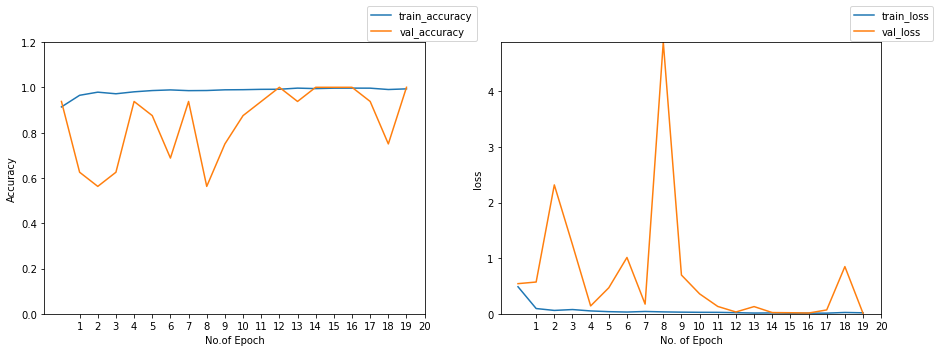

In [24]:
train_loss = r.history['loss']
val_loss = r.history['val_loss']
train_accuracy = r.history['accuracy']
val_accuracy = r.history['val_accuracy']

result_plot(train_accuracy,val_accuracy,train_loss,val_loss)

              precision    recall  f1-score   support

           0       0.95      0.54      0.69       234
           1       0.78      0.98      0.87       390

    accuracy                           0.82       624
   macro avg       0.86      0.76      0.78       624
weighted avg       0.84      0.82      0.80       624



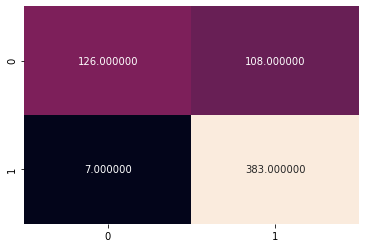

In [25]:
sns.heatmap(confusion_matrix(test_batch.labels,pred_class),cbar = False,annot =True,fmt = 'f')
print(classification_report(test_batch.classes,pred_class))


0.7602564102564102


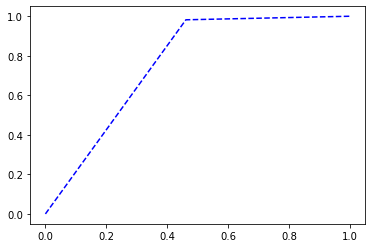

In [26]:
from sklearn.metrics import roc_auc_score,roc_curve

fpr,tpr,th =roc_curve(test_batch.labels,pred_class)
auc_score = roc_auc_score(test_batch.labels,pred_class)
print(auc_score)

plt.plot(fpr,tpr , "b--")

In [27]:
vgg16_model = tf.keras.applications.vgg16.VGG16()

In [28]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [29]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)
for layer in model.layers:
    layer.trainable =False

In [30]:
model.add(Dense(units = 2 ,activation = "softmax"))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [31]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy'
              , metrics=['accuracy'])

r = model.fit(train_batch,
  validation_data=val_batch,
  epochs=20,
  steps_per_epoch=len(train_batch),
  validation_steps=len(val_batch))

Epoch 1/20
174/174 [==============================] - 56s 323ms/step - loss: 0.3026 - accuracy: 0.8788 - val_loss: 0.6056 - val_accuracy: 0.6875
Epoch 2/20
174/174 [==============================] - 58s 331ms/step - loss: 0.1860 - accuracy: 0.9306 - val_loss: 0.3119 - val_accuracy: 0.8750
Epoch 3/20
174/174 [==============================] - 56s 322ms/step - loss: 0.1785 - accuracy: 0.9296 - val_loss: 0.6237 - val_accuracy: 0.7500
Epoch 4/20
174/174 [==============================] - 56s 320ms/step - loss: 0.1521 - accuracy: 0.9442 - val_loss: 0.7078 - val_accuracy: 0.6875
Epoch 5/20
174/174 [==============================] - 56s 320ms/step - loss: 0.1400 - accuracy: 0.9456 - val_loss: 0.5429 - val_accuracy: 0.7500
Epoch 6/20
174/174 [==============================] - 56s 321ms/step - loss: 0.1314 - accuracy: 0.9488 - val_loss: 0.2362 - val_accuracy: 0.8750
Epoch 7/20
174/174 [==============================] - 56s 321ms/step - loss: 0.1284 - accuracy: 0.9521 - val_loss: 0.6365 - val_ac

In [34]:
pred = model.predict(test_batch)
pred_class = model.predict_classes(test_batch)

AUC Score: 0.7478632478632479
              precision    recall  f1-score   support

           0       0.96      0.51      0.66       234
           1       0.77      0.99      0.87       390

    accuracy                           0.81       624
   macro avg       0.86      0.75      0.76       624
weighted avg       0.84      0.81      0.79       624



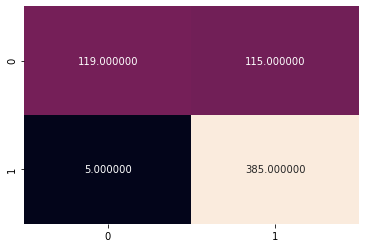

In [35]:
from sklearn.metrics import roc_auc_score,roc_curve

fpr,tpr,th =roc_curve(test_batch.labels,pred_class)
auc_score = roc_auc_score(test_batch.labels,pred_class)
print("AUC Score:",auc_score)


sns.heatmap(confusion_matrix(test_batch.labels,pred_class),cbar = False,annot =True,fmt = 'f')
print(classification_report(test_batch.classes,pred_class))


In [ ]:
plt.plot(fpr,tpr , "b--")